# DOPP 24/25, Group 27, Exercise 2

In order to maintain some level of structure on that big notebook, we will be structuring it in the following sections:

* Introduction  (TODO needed?)
* Imports and constants
* Read-in function
* Dataset descriptions
* Missing data analysis
* Preprocessing functions
* Question 1 to 3

## OPEN POINTS / NEXT STEPS (TODO remove this section before submission)

* I noticed that some data cells in Excel contain no value, while some cells contain zero itself. We should check in which cases Nan and zero means the same, and if there are cases where they do not mean the same.
* finish Data analysis for all datasets
* determine handling of missing values (imputing/removal?)
* For easier break-down, determine which datasets are relevant for which type of questions
* after preproc for all datasets is finished and we know exactly what data we have, check if we need some more data or if we want to change our questions a little bit
* write Introduction chapter


## Introduction

TODO needed?

## Imports and Constants

In [12]:
import seaborn
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from functools import lru_cache

In [13]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl.styles.stylesheet")

In [14]:
# Share of energy from renewable sources                        
NRG_IND_REN = 'data/nrg_ind_ren_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_inf_epcrw__custom_13973000/default/table?lang=en
# Electricity production capacities for renewables and wastes
NRG_INF_EPCRW = 'data/nrg_inf_epcrw_spreadsheet.xlsx'           # https://ec.europa.eu/eurostat/databrowser/view/nrg_ind_ren/default/table?lang=en    
# Simplified energy balances           
NRG_BAL_S = 'data/nrg_bal_s__custom_13973102_spreadsheet.xlsx'  # https://ec.europa.eu/eurostat/databrowser/view/nrg_bal_s__custom_13973102/default/table?lang=en
# Supply and transformation of solid fossil fuels
NRG_CB_SFFM = 'data/nrg_cb_sffm_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_sffm/default/table?lang=en 
# Electricity prices for household consumers          
NRG_PC_204 = 'data/nrg_pc_204_spreadsheet.xlsx'                 # https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_204/default/table?lang=en
# Population by educational attainment level, sex and age
EDAT_LFSE_03 = 'data/edat_lfse_03_spreadsheet.xlsx'             # https://ec.europa.eu/eurostat/databrowser/view/edat_lfse_03/default/table?lang=en
# Gross domestic product at market prices
GDP_MARKET_CAP = 'data/tec00001_page_spreadsheet.xlsx'          # https://ec.europa.eu/eurostat/databrowser/view/tec00001/default/table?lang=en

## Functions for Read In & Dataset Statistics

In [15]:
@lru_cache
def eurostat_dataset(path: str) -> pd.DataFrame:

    # retrieve sheets data and metadata from Summary sheet
    ## the time frequency and unit of measurement information 
    # is not a relevant index value since they are always the same
    ignore = ['Time frequency', 'Unit of measure']
    summary = pd.read_excel(
        path, sheet_name='Summary', 
        usecols=lambda col: \
            not col.startswith('Unnamed') and col not in ignore,
        index_col='Contents', skiprows=14
    )

    all = []

    # iterate over data sheets and pre-process them
    for sheet_name, config in summary.iterrows():

        # the valuable information starts with the row containing "TIME" indicating the start of the data table
        preview = pd.read_excel(path, sheet_name=sheet_name, usecols=[0])
        header_row = preview[preview.iloc[:, 0] == 'TIME'].index[0]

        data = pd.read_excel(
            path, sheet_name=sheet_name,
            usecols= lambda col: not str(col).startswith('Unnamed'),
            na_values=':', skiprows=header_row + 1
        )

        # Remove the first row "Geo (Label)"
        data = data.iloc[1:].reset_index(drop=True)

        # some sheets contain additional meta-data at the end which are seperated by a NaN value row from the actual data
        ## if we find such a row we remove all rows after
        first_blank_row_index = data.isnull().all(axis=1).idxmax() if data.isnull().all(axis=1).any() else None
        if first_blank_row_index is not None:
            data = data.loc[:first_blank_row_index - 1]

        # rename TIME to country
        data.rename(columns={'TIME': 'Country'}, inplace=True)

        # create multi-index based on config
        config_df = pd.DataFrame([config] * len(data), index=data.index)
        data = pd.concat([config_df, data], axis=1)
        data.set_index(['Country'] + list(config_df.columns), inplace=True)

        all.append(data)

    # merge them into one multi-index data frame 
    all = pd.concat(all).sort_index()
    
    return all

In [73]:
def check_for_zeros_and_nans_per_column(df: pd.DataFrame, label: str):
    """
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        label (str): A label to describe the dataset in the analysis.

    Returns:
        list: A list containing:
            - Columns with at least one NaN value and percentage of such columns.
            - Columns with only NaN values and percentage of such columns.
            - Columns with at least one 0 value and percentage of such columns.
            - Columns with only 0 values and percentage of such columns.
            - Percentage of NaN values per column (only columns with >50% NaN included in print).
            - Percentage of 0 values per column (only columns with >50% 0 values included in print).
    """
    # Exclude index columns from analysis
    df_columns_only = df.reset_index().iloc[:, len(df.index.names):]

    total_columns = len(df_columns_only.columns)

    # Columns with at least one NaN value
    nan_any_columns = df_columns_only.columns[df_columns_only.isna().any()].tolist()
    nan_any_percentage = len(nan_any_columns) / total_columns * 100

    # Columns with only NaN values
    nan_only_columns = df_columns_only.columns[df_columns_only.isna().all()].tolist()
    nan_only_percentage = len(nan_only_columns) / total_columns * 100

    # Columns with at least one 0 value
    zero_any_columns = df_columns_only.columns[(df_columns_only == 0).any()].tolist()
    zero_any_percentage = len(zero_any_columns) / total_columns * 100

    # Columns with only 0 values
    zero_only_columns = df_columns_only.columns[(df_columns_only == 0).all()].tolist()
    zero_only_percentage = len(zero_only_columns) / total_columns * 100

    # Percentage of NaN values per column
    nan_percentage_per_column = df_columns_only.isna().mean() * 100
    nan_columns_above_50 = nan_percentage_per_column[nan_percentage_per_column > 50].to_dict()

    # Percentage of 0 values per column
    zero_percentage_per_column = (df_columns_only == 0).mean() * 100
    zero_columns_above_50 = zero_percentage_per_column[zero_percentage_per_column > 50].to_dict()

    # Generate a print statement for the analysis
    print(f"Analysis of {label}:")
    print(f"  Total columns analyzed: {total_columns}")
    print(f"  Columns with at least one NaN value: {len(nan_any_columns)} ({nan_any_percentage:.2f}%)")
    if nan_any_columns:
        print(f"    {nan_any_columns}")
    print(f"  Columns with only NaN values: {len(nan_only_columns)} ({nan_only_percentage:.2f}%)")
    if nan_only_columns:
        print(f"    {nan_only_columns}")
    print(f"  Columns with at least one 0 value: {len(zero_any_columns)} ({zero_any_percentage:.2f}%)")
    if zero_any_columns:
        print(f"    {zero_any_columns}")
    print(f"  Columns with only 0 values: {len(zero_only_columns)} ({zero_only_percentage:.2f}%)")
    if zero_only_columns:
        print(f"    {zero_only_columns}")
    print(f"  Columns with >50% NaN values:")
    for col, perc in nan_columns_above_50.items():
        print(f"    {col}: {perc:.2f}%")
    print(f"  Columns with >50% 0 values:")
    for col, perc in zero_columns_above_50.items():
        print(f"    {col}: {perc:.2f}%")

    '''return [
        {"columns_with_at_least_one_NaN": nan_any_columns, "percentage": nan_any_percentage},
        {"columns_with_only_NaN": nan_only_columns, "percentage": nan_only_percentage},
        {"columns_with_at_least_one_0": zero_any_columns, "percentage": zero_any_percentage},
        {"columns_with_only_0": zero_only_columns, "percentage": zero_only_percentage},
        {"nan_percentage_per_column": nan_percentage_per_column.to_dict()},
        {"zero_percentage_per_column": zero_percentage_per_column.to_dict()}
    ]'''


def data_quality_analysis(df, label):
    """
    Performs data quality analysis on the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        dict: A dictionary containing missing value insights.
    """
    df_columns_only = df.reset_index().iloc[:, len(df.index.names):]

    # Total missing values and percentage
    total_missing = df_columns_only.isna().sum().sum()
    missing_perc_total = (total_missing / df_columns_only.size) * 100

    # Missing values by country
    missing_per_country = df.groupby('Country').apply(lambda x: x.isna().sum().sum())
    missing_perc_country = (missing_per_country / (df_columns_only.shape[1] * len(df.groupby('Country')))) * 100

    # Missing values by time period
    missing_per_time = df_columns_only.isna().mean() * 100

    plt.figure(figsize=(12, 6))
    plt.bar(missing_per_time.index, missing_per_time.values, color='blue', alpha=0.7, label='Missing % by Time Period')
    plt.title(f'{label}: Histogram of Missing Data by Time Period')
    plt.xlabel('Time Periods')
    plt.ylabel('Percentage of Missing Data')
    plt.xticks(rotation=45, fontsize=8, ha='right')
    plt.legend()
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

    '''return {
        "total_missing_values": total_missing,
        "missing_percentage": missing_perc_total,
        "missing_by_country": missing_perc_country,
        "missing_by_time_period": missing_per_time
    }'''


def country_level_analysis(df, label):
    """
    Performs country-level analysis and identifies partial NaN columns.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        dict: A dictionary containing country-level insights and partial NaN columns.
    """
    df_columns_only = df.reset_index().iloc[:, len(df.index.names):]

    # Columns with partial NaNs
    nan_percentage_per_column = df_columns_only.isna().mean() * 100
    partial_nan_columns = nan_percentage_per_column[(nan_percentage_per_column > 0) & (nan_percentage_per_column < 100)]

    # Descriptive statistics by country
    country_stats = df.groupby('Country').apply(lambda group: group.describe().T)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.hist(partial_nan_columns, bins=20, alpha=0.7, color='orange', label='Partial NaN % by Column')
    plt.title(f'{label}: Histogram of Partial NaN Data by Column')
    plt.xlabel('Percentage of NaN Data')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    '''return {
        "partial_nan_columns": partial_nan_columns,
        "country_stats": country_stats
    }'''


def temporal_trends_analysis(df, label):
    """
    Analyzes temporal trends in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        dict: A dictionary containing temporal trends and year-over-year changes.
    """
    df_columns_only = df.reset_index().iloc[:, len(df.index.names):]

    # Aggregate data by time period to identify trends
    time_trends = df_columns_only.mean()

    # Year-over-Year (YoY) percentage change
    yearly_trends = time_trends.resample('Y').mean() if df_columns_only.columns.str.contains('-').any() else time_trends
    yoy_change = yearly_trends.pct_change().dropna() * 100

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(time_trends, label=f'{label}: Mean Value by Time')
    plt.title('Temporal Trends')
    plt.xlabel('Time')
    plt.xticks(rotation=45, fontsize=8, ha='right')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.show()

    '''return {
        "time_trends": time_trends,
        "yoy_change": yoy_change
    }'''


def visualize_country_data(df: pd.DataFrame, label: str):
    """
    Summarizes and visualizes data for each country.
    1. Sums values across all index columns except 'Country'.
    2. Visualizes total summed values for each country.
    3. Creates a heatmap showing missing years for each country.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a multi-level index and year columns.
        label (str): A label to describe the dataset in the visualization.

    Returns:
        dict: A dictionary containing the summarized data and missing data insights.
    """
    # Sum over all index levels except 'Country'
    summed_df = df.groupby(level='Country').sum()

    # Binary matrix for missing data visualization
    missing_data_visual = summed_df.notna().astype(int)  # Convert to binary (1=present, 0=missing)

    # Visualization 1: Total summed values for each country
    plt.figure(figsize=(12, 6))
    summed_df.sum(axis=1).sort_values(ascending=False).plot(kind='bar', color='steelblue', alpha=0.7)
    plt.title(f'Total Summed Values by Country ({label})')
    plt.xlabel('Country')
    plt.ylabel('Total Summed Values')
    plt.xticks(rotation=45, fontsize=8, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualization 2: Heatmap of missing data
    plt.figure(figsize=(15, 8))
    sns.heatmap(missing_data_visual, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='gray')
    plt.title(f'Missing Data Heatmap by Year and Country ({label})')
    plt.xlabel('Year')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()

    return {
        "summed_data": summed_df,
        "missing_data": missing_data_visual
    }
    raise NotImplementedError # TODO visualization which is able to show which years are available per country



def analyze_dataframe(df, label):
    """
    Orchestrates the overall analysis of the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        label (str):

    Returns:
        dict: A dictionary with results from all analyses.
    """
    print(f"### Running Data Analysis for {label} ###")
    check_for_zeros_and_nans_per_column(df, label)
    visualize_country_data(df, label)
    data_quality_results = data_quality_analysis(df, label)
    country_level_results = country_level_analysis(df, label)
    temporal_trends_results = temporal_trends_analysis(df, label)

    '''return {
        "data_quality": data_quality_results,
        "country_level": country_level_results,
        "temporal_trends": temporal_trends_results
    }'''


## Dataset Descriptions

### File Structures

Each of the 6 Excel-files contains two standardized worksheets for metadata, namely 'Summary' and 'Structure', and the actual data contained in that file is split across the (multiple) other worksheets.

* 'Summary' contains some metadata (e.g. short description,links), plus a list of additional worksheets where the actual data is contained. Each entry in that list consists at least of the worksheet-name, the unit of measure and the time frequency (always annual?), plus some file-specific columns.
* 'Structure' contains the descriptions (e.g., Germany is a geopolitical entity, or Exports is of dimension Energy Balance) for all dimensions mentioned in that Excel file. It is however not directly relevant when reading in the data for this project and also not processed.
* All other sheets (all of them contain actual data) have some kind of header (around 10 rows), then the actual data, and afterwards maybe some additional stuff (e.g. flag explanation). The actual data is always the same: Country as a row, value for a given year OR year+month as column.

### Dataset 1: Population by educational attainment level, sex and age

TODO do we even need this dataset? potentially remove at the end if not needed

**This dataframe is multi-indexed by those 4 columns**:
- Country
- Sex (Total, Males, Females)
- Age class (a lot of different areas, all equal to or in between 15 and 64) TODO preprocess column
- Level of education TODO preprocess column

**Unit of measure**: Percentage (e.g., in 1995, 41.4% of Austrian Females between 15 and 64 had education level 0-2, while 5.9% had education level 5-8 and 52.7% had level 3-4) TODO is that correct?

**Time:** Annually

**Available flags**:

* (:) - not available
* (b) - break in time series
* (u) - low reliability
* (bu) - break in time series, low reliability

TODO if we need the dataset, we should double-check if the percentages sum up to 100 everywhere!

In [26]:
df_population_by_education_sex_age = eurostat_dataset(EDAT_LFSE_03)
label_df_population_by_education_sex_age = 'Population by educational, sex and age'
df_population_by_education_sex_age.head(10)

1992  \
Country Sex     Age class           International Standard Classification of Educat...        
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...  NaN   
                                    Tertiary education (levels 5-8)                     NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   
                                    Upper secondary, post-secondary non-tertiary an...  NaN   
                From 20 to 24 years Less than primary, primary and lower secondary ...  NaN   
                                    Tertiary education (levels 5-8)                     NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   
                                    Upper secondary and post-secondary non-tertiary...  NaN   

                                                                                        1993  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...   NaN   
                                    Tertiary education (levels 5-8)                      NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary, post-secondary non-tertiary an...   NaN   
                From 20 to 24 years Less than primary, primary and lower secondary ...   NaN   
                                    Tertiary education (levels 5-8)                      NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   

                                                                                        1994  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...   NaN   
                                    Tertiary education (levels 5-8)                      NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary, post-secondary non-tertiary an...   NaN   
                From 20 to 24 years Less than primary, primary and lower secondary ...   NaN   
                                    Tertiary education (levels 5-8)                      NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-secondary non-tertiary...   NaN   

                                                                                        1995  \
Country Sex     Age class           International Standard Classification of Educat...         
Austria Females From 15 to 64 years Less than primary, primary and lower secondary ...  41.4   
                                    Tertiary education (levels 5-8)                      5.9   
                                    Upper secondary and post-secondary non-tertiary...  52.7   
                                    Upper secondary and post-secondary non-tertiary...   NaN   
                                    Upper secondary and post-sec

### Dataset 2: Simplified energy balances

One can see the annually aggregated values of various **energy balances for the following multi-level index**:
- Country
- Energy balance, which is either
    * Available for final consumption
    * Gross available energy
    * Primary energy consumption (Europe 2020-2023) (this one was removed, as there are a lot of NaN's for a lot of countries)
    * Total energy supply

(The column 'Standard international energy product classification (SIEC)' always contains the value 'Total' and will therefore be removed.)

**Unit of measure** is Gigawatt-hours (GWh) (e.g., in 1990, Albanias Total Energy supply was 31086.839 GWh)

**Time:** Annualy

**Available flags:**

* : - not available

In [83]:
df_energy_balances_by_country = eurostat_dataset(NRG_BAL_S)
label_df_energy_balances_by_country = 'Energy Balances by country'

# remove index column 'Standard international energy product classification (SIEC)'
df_reset = df_energy_balances_by_country.reset_index().drop(columns=['Standard international energy product classification (SIEC)'])

# filter out the rows for 'Primary energy consumption (Europe 2020-2030)'
df_filtered = df_reset[df_reset['Energy balance'] != 'Primary energy consumption (Europe 2020-2030)']
df_energy_balances_by_country = df_filtered.set_index(['Country', 'Energy balance'])

df_energy_balances_by_country.head(15)

1990  \
Country                Energy balance                                
Albania                Available for final consumption   25468.502   
                       Gross available energy            31086.839   
                       Total energy supply               31086.839   
Austria                Available for final consumption  227893.897   
                       Gross available energy           294766.068   
                       Total energy supply              291185.346   
Belgium                Available for final consumption  360837.846   
                       Gross available energy           614412.772   
                       Total energy supply              555608.216   
Bosnia and Herzegovina Available for final consumption         NaN   
                       Gross available energy                  NaN   
                       Total energy supply                     NaN   
Bulgaria               Available for final consumption   203243.14   
                       Gross available energy               328661   
                       Total energy supply              325156.889   

                                                              1991  \
Country                Energy balance                                
Albania                Available for final consumption   17375.307   
                       Gross available energy            21758.512   
                       Total energy supply               21758.512   
Austria                Available for final consumption  244309.138   
                       Gross available energy           313485.830   
                       Total energy supply              309504.886   
Belgium                Available for final consumption  384674.143   
                       Gross available energy           640104.577   
                       Total energy supply              580739.882   
Bosnia and Herzegovina Available for final consumption         NaN   
                       Gross available energy                  NaN   
                       Total energy supply                     NaN   
Bulgaria               Available for final consumption  151071.041   
                       Gross available energy           266599.500   
                       Total energy supply              260364.888   

                                                              1992  \
Country                Energy balance                                
Albania                Available for final consumption   12569.078   
                       Gross available energy            15796.031   
                       Total energy supply               15796.031   
Austria                Available for final consumption  238581.580   
                       Gross available energy           301327.038   
                       Total energy supply              297043.038   
Belgium                Available for final consumption  395572.582   
                       Gross available energy           646297.818   
                       Total energy supply              587758.095   
Bosnia and Herzegovina Available for final consumption         NaN   
                       Gross available energy                  NaN   
                       Total energy supply                     NaN   
Bulgaria               Available for final consumption  126475.644   
                       Gross available energy           244441.248   
                       Total energy supply              237594.081   

                                                              1993  \
Country                Energy balance                                
Albania                Available for final consumption   11468.949   
                       Gross available energy            15480.885   
                       Total energy supply               15480.885   
Austria                Available for final consumption  242053.195   
                       Gross available energy           305054.609   

### Running Data Analysis for Energy Balances by country ###
Analysis of Energy Balances by country:
  Total columns analyzed: 34
  Columns with at least one NaN value: 28 (82.35%)
    ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2020', '2021', '2022', '2023']
  Columns with only NaN values: 1 (2.94%)
    ['2023']
  Columns with at least one 0 value: 0 (0.00%)
  Columns with only 0 values: 0 (0.00%)
  Columns with >50% NaN values:
    2023: 100.00%
  Columns with >50% 0 values:


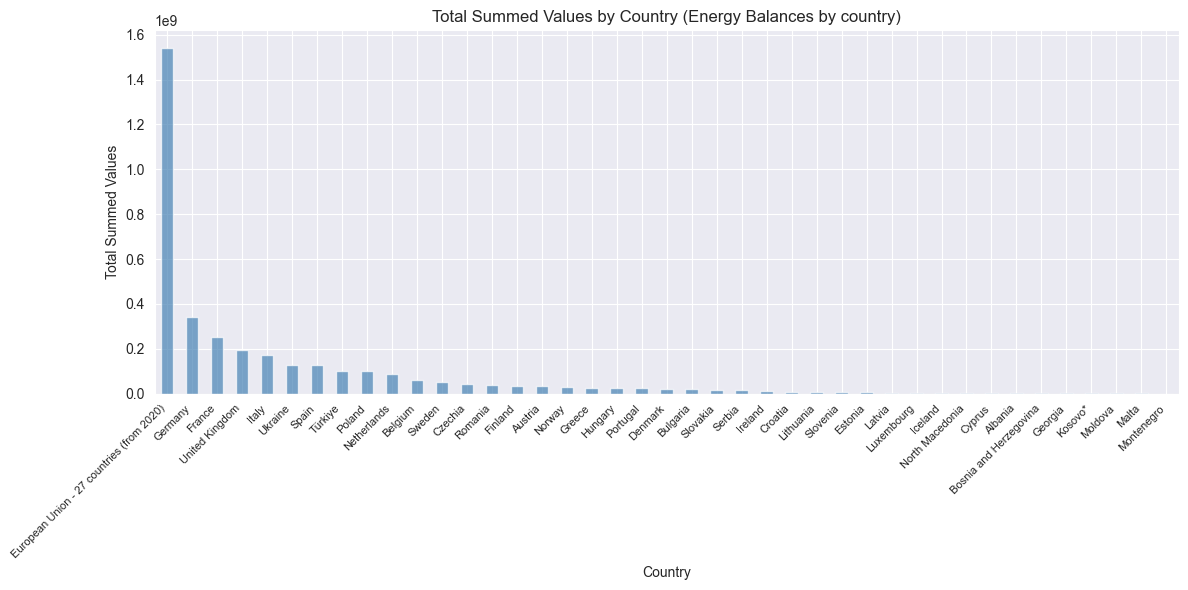

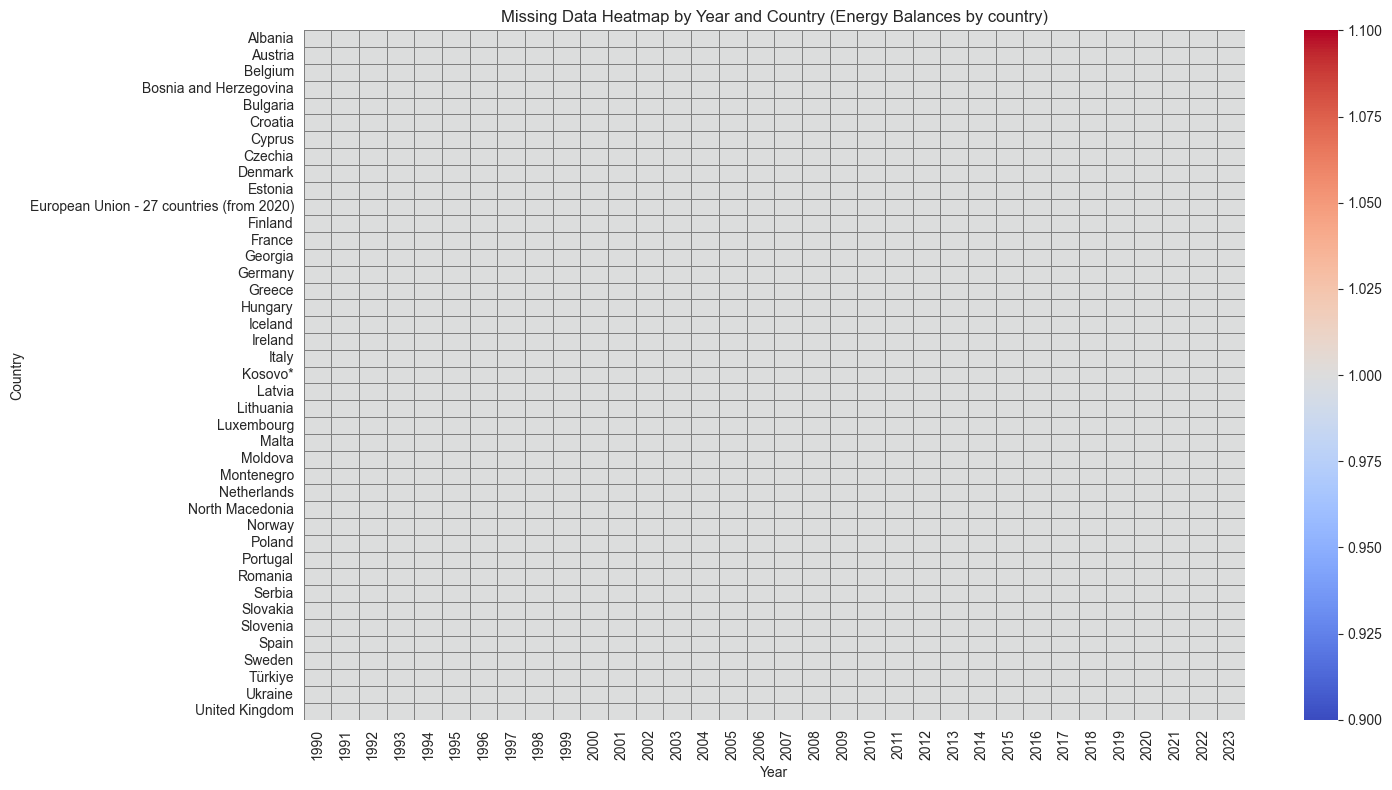

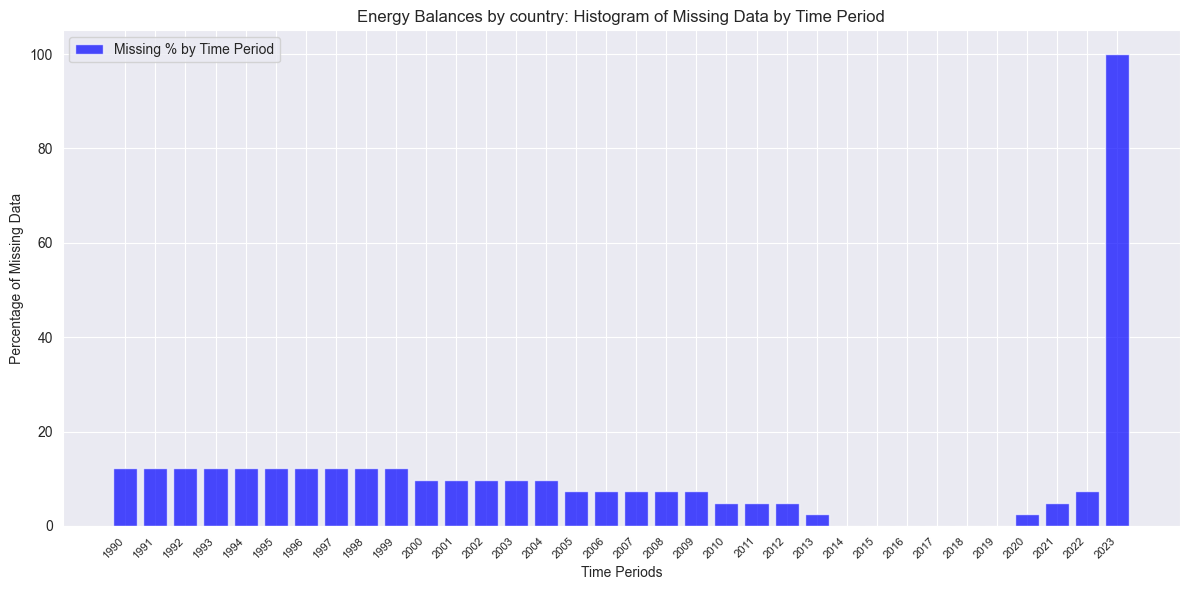

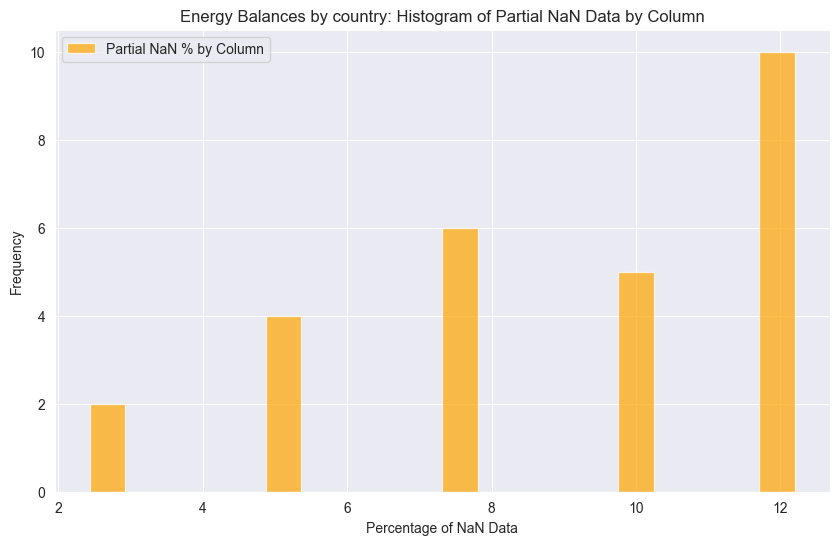

/var/folders/5c/r0r98wnj7xx1b0tt595pdz100000gn/T/ipykernel_27391/2083530036.py:169: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folders/5c/r0r98wnj7xx1b0tt595pdz100000gn/T/ipykernel_27391/2083530036.py:169: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



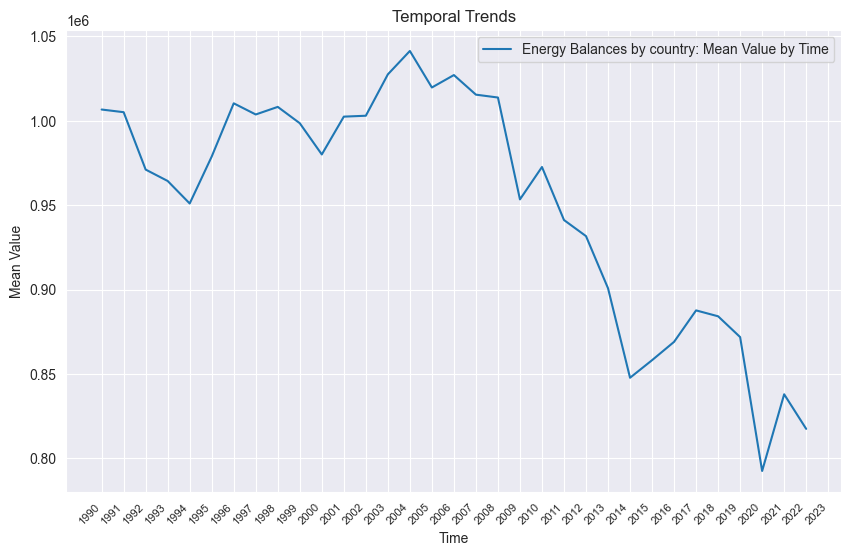

In [82]:
analyze_dataframe(df_energy_balances_by_country, label_df_energy_balances_by_country)

In [ ]:
# TODO check out data description graphics, can be better

### Dataset 3: Supply and transformation of solid fossil fuels

**Unit of measure**: Thousand tonnes TODO how to exactly interpret this?

**Time**: Monthly. TODO should we aggregate to annually?

**Multi-Level-Index is currently the following:**

* 'Energy balance', which can be: (TODO that's way too much different values, isn't it?)
    * Indigenous production
    * Recovered and recycled products
    * Imports
    * Imports from outside EU
    * Exports
    * Opening stocks on national territory
    * Closing stocks on national territory
    * Change in stock
    * Gross inland deliveries - calculated
    * Gross inland deliveries - observed
    * Transformation input - electricity and heat generation - main activity producers
    * Transformation input - coke ovens
    * Final consumption - industry sector
    * Final consumption - industry sector - iron and steel
    * Final consumption - other sectors
    * Statistical differences

* 'Standard international energy product classification (SIEC)', which can be:
    * Hard coal
    * Brown coal
    * Coke oven coke
    * Peat
    * Oil shale and oil sands

**Available flags:**
* : -	not available
* bn -	break in time series, not significant
* b -	break in time series
* e -	estimated
* n -	not significant
* p -	provisional
* TODO except the flag ':', the flags have been in different columns than the values (an additional one next to the month-column) and are therefore currently not available! Should we add them? How much do we care about the various flags?

In [85]:
df_fossil_fuels = eurostat_dataset(NRG_CB_SFFM)
df_fossil_fuels.head(15)

2008-01  \
Country Energy balance                       Standard international energy product classific...           
Albania Change in stock                      Brown coal                                             NaN   
                                             Coke oven coke                                         NaN   
                                             Hard coal                                              NaN   
                                             Oil shale and oil sands                                NaN   
                                             Peat                                                   NaN   
        Closing stocks on national territory Brown coal                                             NaN   
                                             Coke oven coke                                         NaN   
                                             Hard coal                                              NaN   
                                             Oil shale and oil sands                                NaN   
                                             Peat                                                   NaN   
        Exports                              Brown coal                                             NaN   
                                             Coke oven coke                                         NaN   
                                             Hard coal                                              NaN   
                                             Oil shale and oil sands                                NaN   
                                             Peat                                                   NaN   

                                                                                                 2008-02  \
Country Energy balance                       Standard international energy product classific...            
Albania Change in stock                      Brown coal                                              NaN   
                                             Coke oven coke                                          NaN   
                                             Hard coal                                               NaN   
                                             Oil shale and oil sands                                 NaN   
                                             Peat                                                    NaN   
        Closing stocks on national territory Brown coal                                              NaN   
                                             Coke oven coke                                          NaN   
                                             Hard coal                                               NaN   
                                             Oil shale and oil sands                                 NaN   
                                             Peat                                                    NaN   
        Exports                              Brown coal                                              NaN   
                                             Coke oven coke                                          NaN   
                                             Hard coal                                               NaN   
                                             Oil shale and oil sands                                 NaN   
                                             Peat                                                    NaN   

                                                                                                 2008-03  \
Country Energy balance                       Standard international energy product classific...            
Albania Change in stock                      Brown coal                                              NaN   
                                             Coke oven coke                                          NaN   
       

In [ ]:
# TODO ADD ALL DATASETS

## Missing data

### Reasons for missing data

TODO add reason if we find additional ones

1. **no data available before a given threshold**
   can be the case if the given data was not collected by the government until some time
2. **other reasons**
   Placeholder for all missing data where we cannot find a direct pattern/reason, TODO add 1-2 examples when we find some

TODO analyse missing values and derive strategies for handling the various different categories

## Preprocessing functions

In [ ]:
# TODO add preprocessing functions here to prepare data for question answering

## Question 1: How is the adoption of renewable energy in Europe evolving?

In [16]:
energy_share = eurostat_dataset(NRG_IND_REN)

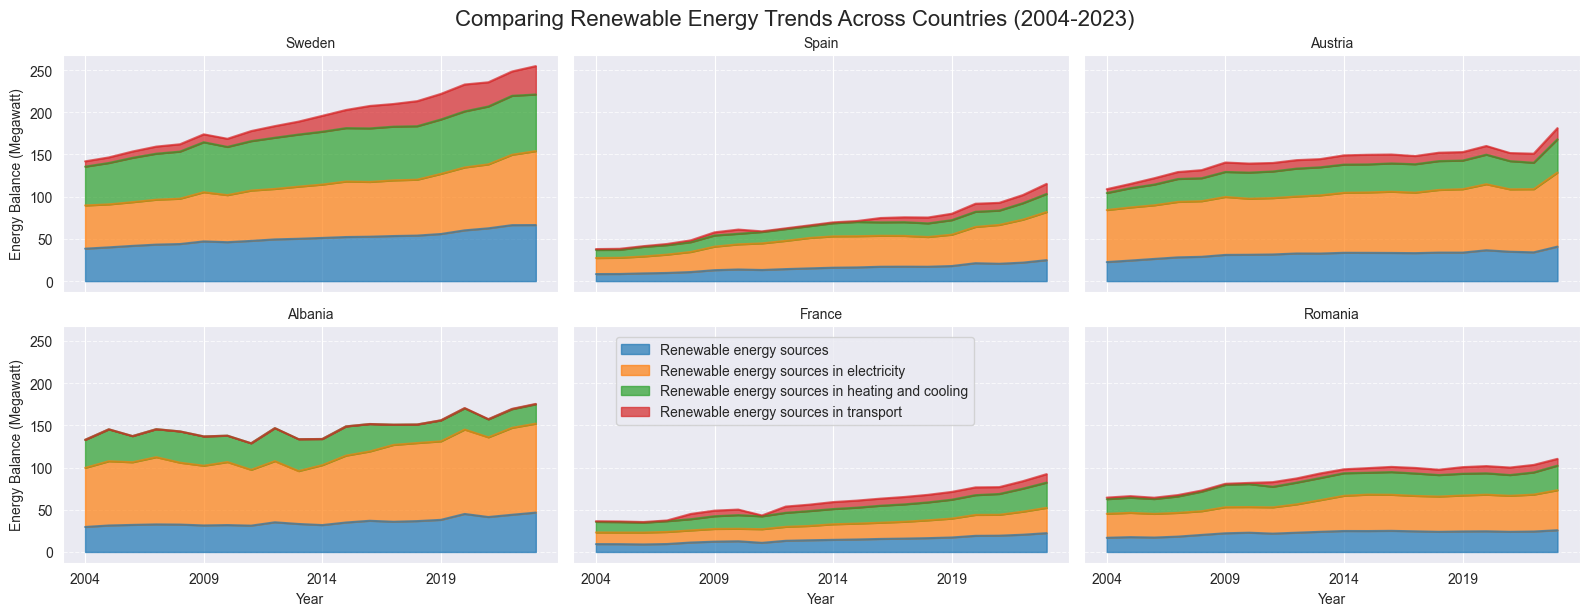

In [17]:
# Select a subset of countries for comparison
countries_to_compare = ("Sweden", "Spain", "Austria", "Albania", "France", "Romania")
comparison_data = energy_share.loc[energy_share.index.get_level_values('Country').isin(countries_to_compare)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(countries_to_compare):
    country_data = comparison_data.loc[country]
    
    country_data.T.plot(kind='area', stacked=True, alpha=0.7, ax=axes[idx], legend=False)
    
    axes[idx].set_title(country, fontsize=10)
    axes[idx].set_xlabel("Year", fontsize=10)
    axes[idx].set_ylabel("Energy Balance (Megawatt)", fontsize=10)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 0.4), ncol=1, fontsize=10)

plt.tight_layout()
plt.suptitle("Comparing Renewable Energy Trends Across Countries (2004-2023)", fontsize=16, y=1.02)
plt.show()

In [18]:
melted_data = energy_share.reset_index().melt(id_vars=["Country", "Energy balance"], var_name="Year", value_name="Energy Balance")

renewable_data = melted_data[melted_data["Energy balance"] == "Renewable energy sources"].copy()
renewable_data["Year"] = renewable_data["Year"]
renewable_data["Energy Balance"] = renewable_data["Energy Balance"].infer_objects()

fig = px.choropleth(
    renewable_data,
    range_color=(renewable_data['Energy Balance'].min(), renewable_data['Energy Balance'].max()),
    locations="Country",
    locationmode="country names",
    color="Energy Balance",
    projection="natural earth",
    hover_name="Country",
    animation_frame="Year",
    # title="Renewable Energy Trends Across the EU (2004-2023)",
    scope="europe"
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Question 2: How is the adoption of different types of renewable energy evolving?

In [19]:
# TODO: work on it
energy_prod_cap = eurostat_dataset(NRG_INF_EPCRW)
energy_prod_cap

1990  \
Country        Standard international energy product classific... Technical characteristics of plants                       
Albania        Biogases                                           Net maximum electrical capacity                       0   
                                                                  Net maximum electrical capacity - alternating c...  NaN   
                                                                  Net maximum electrical capacity - direct current    NaN   
               Geothermal                                         Net maximum electrical capacity                       0   
                                                                  Net maximum electrical capacity - alternating c...  NaN   
...                                                                                                                   ...   
United Kingdom Wind off shore                                     Net maximum electrical capacity - alternating c...  NaN   
                                                                  Net maximum electrical capacity - direct current    NaN   
               Wind on shore                                      Net maximum electrical capacity                       0   
                                                                  Net maximum electrical capacity - alternating c...  NaN   
                                                                  Net maximum electrical capacity - direct current    NaN   

                                                                                                                      1991  \
Country        Standard international energy product classific... Technical characteristics of plants                        
Albania        Biogases                                           Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   
               Geothermal                                         Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
...                                                                                                                    ...   
United Kingdom Wind off shore                                     Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   
               Wind on shore                                      Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   

                                                                                                                      1992  \
Country        Standard international energy product classific... Technical characteristics of plants                        
Albania        Biogases                                           Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacity - alternating c...   NaN   
                                                                  Net maximum electrical capacity - direct current     NaN   
               Geothermal                                         Net maximum electrical capacity                      0.0   
                                                                  Net maximum electrical capacit

## Question 3: Are there characteristics of countries that correlate with their level of adoption of renewable energy?

In [20]:
# TODO: work on it
energy_prices = eurostat_dataset(NRG_PC_204)
energy_prices

2007-S1  \
Country        Products          Energy consumption                           Taxes                                              Currency                            
Albania        Electrical energy Consumption for 15 000 kWh or over - band DE All taxes and levies included                      Euro                          NaN   
                                                                                                                                 National currency             NaN   
                                                                                                                                 Purchasing Power Standard     NaN   
                                                                              Excluding VAT and other recoverable taxes and l... Euro                          NaN   
                                                                                                                                 National currency             NaN   
...                                                                                                                                                            ...   
United Kingdom Electrical energy Consumption of kWh - all bands               Excluding VAT and other recoverable taxes and l... National currency             NaN   
                                                                                                                                 Purchasing Power Standard     NaN   
                                                                              Excluding taxes and levies                         Euro                          NaN   
                                                                                                                                 National currency             NaN   
                                                                                                                                 Purchasing Power Standard     NaN   

                                                                                                                                                            2007-S2  \
Country        Products          Energy consumption                           Taxes                                              Currency                             
Albania        Electrical energy Consumption for 15 000 kWh or over - band DE All taxes and levies included                      Euro                           NaN   
                                                                                                                                 National currency              NaN   
                                                                                                                                 Purchasing Power Standard      NaN   
                                                                              Excluding VAT and other recoverable taxes and l... Euro                           NaN   
                                                                                                                                 National currency              NaN   
...                                                                                                                                                             ...   
United Kingdom Electrical energy Consumption of kWh - all bands               Excluding VAT and other recoverable taxes and l... National currency              NaN   
                                                                                                                                 Purchasing Power Standard      NaN   
                                                                              Excluding taxes and levies                         Euro                           NaN   
                                                                                                                                 National currency             

In [22]:
edat = eurostat_dataset(EDAT_LFSE_03)
edat

KeyboardInterrupt: 